In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import time

import numpy as np
import pandas as pd

from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model   # 네트워크 입출력 시각화

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

In [2]:
x = [i for i in np.arange(start=-10, stop=10, step=0.1)] # -10 ~ 10까지 0.1 단위로 구간 분할
print(len(x))
print(x)

200
[-10.0, -9.9, -9.8, -9.700000000000001, -9.600000000000001, -9.500000000000002, -9.400000000000002, -9.300000000000002, -9.200000000000003, -9.100000000000003, -9.000000000000004, -8.900000000000004, -8.800000000000004, -8.700000000000005, -8.600000000000005, -8.500000000000005, -8.400000000000006, -8.300000000000006, -8.200000000000006, -8.100000000000007, -8.000000000000007, -7.9000000000000075, -7.800000000000008, -7.700000000000008, -7.6000000000000085, -7.500000000000009, -7.400000000000009, -7.30000000000001, -7.20000000000001, -7.10000000000001, -7.000000000000011, -6.900000000000011, -6.800000000000011, -6.700000000000012, -6.600000000000012, -6.500000000000012, -6.400000000000013, -6.300000000000013, -6.2000000000000135, -6.100000000000014, -6.000000000000014, -5.900000000000015, -5.800000000000015, -5.700000000000015, -5.600000000000016, -5.500000000000016, -5.400000000000016, -5.300000000000017, -5.200000000000017, -5.100000000000017, -5.000000000000018, -4.9000000000000

In [3]:
# sin 함수 학습 데이터
train_y = [np.sin(i) for i in x] # sin 값으로 변경
for i in range(50):
    if (i >= 15):
        # 앞쪽 15건의 데이터를 이용하여 y 예측 표시, 16번째 데이터부터 y로 인식되기 시작
        print((i+1), train_y[i], ' <- y') 
    else:    
        print((i+1), train_y[i])

1 0.5440211108893698
2 0.45753589377532133
3 0.3664791292519284
4 0.2717606264109442
5 0.1743267812229814
6 0.07515112046181108
7 -0.02477542545335599
8 -0.12445442350705994
9 -0.2228899141002442
10 -0.31909836234934874
11 -0.4121184852417533
12 -0.5010208564578816
13 -0.5849171928917588
14 -0.6629692300821793
15 -0.7343970978741098
16 -0.798487112623487  <- y
17 -0.8545989080882778  <- y
18 -0.9021718337562911  <- y
19 -0.9407305566797707  <- y
20 -0.9698898108450846  <- y
21 -0.9893582466233808  <- y
22 -0.9989413418397717  <- y
23 -0.9985433453746054  <- y
24 -0.9881682338770016  <- y
25 -0.9679196720314885  <- y
26 -0.9379999767747419  <- y
27 -0.8987080958116308  <- y
28 -0.8504366206285696  <- y
29 -0.7936678638491591  <- y
30 -0.7289690401258833  <- y
31 -0.6569865987187972  <- y
32 -0.5784397643882089  <- y
33 -0.4941133511386182  <- y
34 -0.4048499206166089  <- y
35 -0.3115413635133897  <- y
36 -0.21511998808782767  <- y
37 -0.11654920485050599  <- y
38 -0.016813900484363032  

In [4]:
print(train_y[0])
print(train_y[1])
print(train_y[2])
print(train_y[15]) # 16번째
print(train_y[16]) # 17번째

0.5440211108893698
0.45753589377532133
0.3664791292519284
-0.798487112623487
-0.8545989080882778


In [5]:
# time step 만큼 시퀀스 데이터 분리
def split_sequence(sequence, timestep):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_idx = i + timestep # 15, 16, 17, 18...
        if end_idx > len(sequence) - 1:
            break

        # seq_x: 0 ~ 14, seq_y: 15
        # seq_x: 1~ 15, seq_y: 16
        # seq_x: 2~ 16, seq_y: 17
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx] 
        
        x.append(seq_x) # 2차원 list
        y.append(seq_y)

    return np.array(x), np.array(y)

In [6]:
# 하이퍼파라미터
n_timesteps = 15  # 15개가 모여서 결과를 쿨력, 입력 시퀀스 길이, 메모리셀은 15개가됨.
n_features = 1    # 입력 변수의 갯수 1개, 특성 벡터의 갯수

In [7]:
# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, timestep=n_timesteps)
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape), '\n')
print('train_x[0]:', train_x[0])
print('train_y[0]:', train_y[0], '\n')
print('train_x[1]:', train_x[1])
print('train_y[1]:', train_y[1])

shape x:(185, 15) / y:(185,) 

train_x[0]: [ 0.54402111  0.45753589  0.36647913  0.27176063  0.17432678  0.07515112
 -0.02477543 -0.12445442 -0.22288991 -0.31909836 -0.41211849 -0.50102086
 -0.58491719 -0.66296923 -0.7343971 ]
train_y[0]: -0.798487112623487 

train_x[1]: [ 0.45753589  0.36647913  0.27176063  0.17432678  0.07515112 -0.02477543
 -0.12445442 -0.22288991 -0.31909836 -0.41211849 -0.50102086 -0.58491719
 -0.66296923 -0.7343971  -0.79848711]
train_y[1]: -0.8545989080882778


In [8]:
# RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [samples, timesteps, features]
# 행, 열, 입력 벡터 차원(변수의 갯수)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features) 
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

train_x.shape = (185, 15, 1)
train_y.shape = (185,)


In [9]:
# RNN 모델 정의
model = Sequential()
# units=10: rnn 계층에 존재하는 전체 뉴런수
# return_sequences=False: 은닉 상태값을 출력할지 결정
# False: 마지막 시점의 메모리 셀에서만 결과를 출력, True: 모든 rnn 계산과정에서 결과를 출력
# return_sequences는 다층 구조의 rnn 모델이나 one-to-many, many-to-many구조에서 사용
# input_shape=(n_timesteps, n_features): 입력 시퀀스 길이, 변수의 갯수
model.add(SimpleRNN(units=10, return_sequences=False, input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
es = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
mc = ModelCheckpoint('./RNN.h5', monitor='loss', verbose=1, save_best_only=True)

start = time.time()
hist = model.fit(train_x, train_y, validation_split=0.3, 
                 shuffle=True, epochs=1000, callbacks=[es, mc])
print('time:', time.time() - start)

Epoch 1/1000
5/5 [==============================] - 2s 201ms/step - loss: 0.0703 - val_loss: 0.0349

Epoch 00001: loss improved from inf to 0.06515, saving model to .\RNN.h5
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0260 - val_loss: 0.0078

Epoch 00002: loss improved from 0.06515 to 0.02329, saving model to .\RNN.h5
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0043

Epoch 00003: loss improved from 0.02329 to 0.00604, saving model to .\RNN.h5
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0060

Epoch 00004: loss improved from 0.00604 to 0.00519, saving model to .\RNN.h5
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0041

Epoch 00005: loss improved from 0.00519 to 0.00517, saving model to .\RNN.h5
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0032 - val_loss: 0.0014

Epoch 00006: loss 


Epoch 00047: loss improved from 0.00005 to 0.00005, saving model to .\RNN.h5
Epoch 48/1000
5/5 [==============================] - 0s 15ms/step - loss: 4.5927e-05 - val_loss: 4.2861e-05

Epoch 00048: loss did not improve from 0.00005
Epoch 49/1000
5/5 [==============================] - 0s 13ms/step - loss: 4.8238e-05 - val_loss: 3.9982e-05

Epoch 00049: loss did not improve from 0.00005
Epoch 50/1000
5/5 [==============================] - 0s 16ms/step - loss: 5.3080e-05 - val_loss: 3.9649e-05

Epoch 00050: loss did not improve from 0.00005
Epoch 51/1000
5/5 [==============================] - 0s 15ms/step - loss: 4.8128e-05 - val_loss: 3.7914e-05

Epoch 00051: loss did not improve from 0.00005
Epoch 52/1000
5/5 [==============================] - 0s 14ms/step - loss: 4.1701e-05 - val_loss: 3.7014e-05

Epoch 00052: loss improved from 0.00005 to 0.00005, saving model to .\RNN.h5
Epoch 53/1000
5/5 [==============================] - 0s 16ms/step - loss: 4.3091e-05 - val_loss: 4.0663e-05

Epo

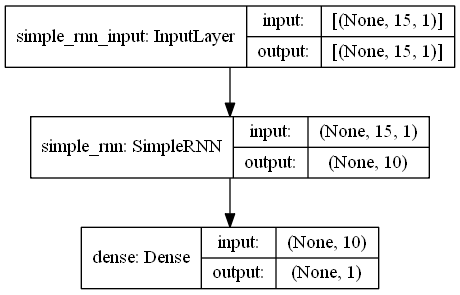

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True)

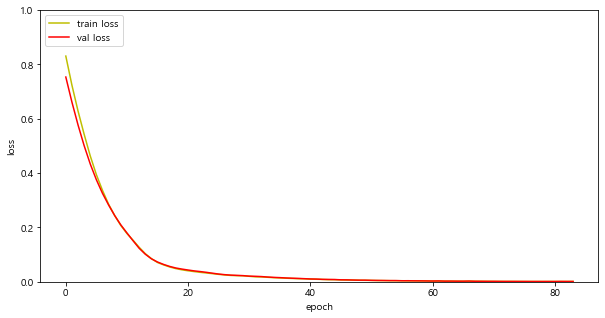

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차

loss_ax.legend(loc='upper left') # 오차 레이블 위치

plt.show()

In [12]:
# 테스트 데이터셋 생성
test_x = np.arange(0, 10, 0.1)
# test_x = np.arange(10, 20, 0.1)
# test_x = np.arange(-10, 10, 0.1)
# test_x = np.arange(-30, 30, 0.1)
print(len(test_x))
calc_y = np.sin(test_x) # 테스트 정답 데이터
print(calc_y)

100
[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99749499  0.9995736   0.99166481
  0.97384763  0.94630009  0.90929743  0.86320937  0.8084964   0.74570521
  0.67546318  0.59847214  0.51550137  0.42737988  0.33498815  0.23924933
  0.14112001  0.04158066 -0.05837414 -0.15774569 -0.2555411  -0.35078323
 -0.44252044 -0.52983614 -0.61185789 -0.68776616 -0.7568025  -0.81827711
 -0.87157577 -0.91616594 -0.95160207 -0.97753012 -0.993691   -0.99992326
 -0.99616461 -0.98245261 -0.95892427 -0.92581468 -0.88345466 -0.83226744
 -0.77276449 -0.70554033 -0.63126664 -0.55068554 -0.46460218 -0.37387666
 -0.2794155  -0.1821625  -0.0830894   0.0168139   0.1165492   0.21511999
  0.31154136  0.40484992  0.49411335  0.57843976  0.6569866   0.72896904
  0.79366786  0.85043662  0.8987081   0.93799998  0.96791967  0.98816823
  0.99854335  0.99894134  0.98935825  0.9698898

In [13]:
# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps] # calc_y[:15]
for i in range(len(test_x) - n_timesteps): # 100 - 15 = 85: 0 ~ 84
    net_input = test_y[i : i + n_timesteps] # 0 ~ 15
    net_input = net_input.reshape((1, n_timesteps, n_features)) # 1, 15, 1
    
    train_y = model.predict(net_input, verbose=0) # 모델 사용
    
    print(test_y.shape, train_y.shape, i, i + n_timesteps) # 결과 출력
    
    test_y = np.append(test_y, train_y) # 그래프용
    print('->', test_y)

(15,) (1, 1) 0 15
-> [0.         0.09983342 0.19866933 0.29552021 0.38941834 0.47942554
 0.56464247 0.64421769 0.71735609 0.78332691 0.84147098 0.89120736
 0.93203909 0.96355819 0.98544973 0.99719185]
(16,) (1, 1) 1 16
-> [0.         0.09983342 0.19866933 0.29552021 0.38941834 0.47942554
 0.56464247 0.64421769 0.71735609 0.78332691 0.84147098 0.89120736
 0.93203909 0.96355819 0.98544973 0.99719185 0.97401291]
(17,) (1, 1) 2 17
-> [0.         0.09983342 0.19866933 0.29552021 0.38941834 0.47942554
 0.56464247 0.64421769 0.71735609 0.78332691 0.84147098 0.89120736
 0.93203909 0.96355819 0.98544973 0.99719185 0.97401291 0.94494903]
(18,) (1, 1) 3 18
-> [0.         0.09983342 0.19866933 0.29552021 0.38941834 0.47942554
 0.56464247 0.64421769 0.71735609 0.78332691 0.84147098 0.89120736
 0.93203909 0.96355819 0.98544973 0.99719185 0.97401291 0.94494903
 0.90173221]
(19,) (1, 1) 4 19
-> [0.         0.09983342 0.19866933 0.29552021 0.38941834 0.47942554
 0.56464247 0.64421769 0.71735609 0.78332

(41,) (1, 1) 26 41
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647]
(42,) (1, 1) 27 42
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46

(55,) (1, 1) 40 55
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647
 -0.82744801 -0.90634388 -0.95945293 -0.9789533  -1.01784074 -1.00297403
 -0.99321765 -0.93730634 -0.87838084 -0.8683188  -0.7570383  -0.72977209
 -0.72286111 -0.58049959]
(56,) (1, 1) 41 56
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70

(70,) (1, 1) 55 70
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647
 -0.82744801 -0.90634388 -0.95945293 -0.9789533  -1.01784074 -1.00297403
 -0.99321765 -0.93730634 -0.87838084 -0.8683188  -0.7570383  -0.72977209
 -0.72286111 -0.58049959 -0.59754515 -0.56558436 -0.40537727 -0.43605393
 -0.34775519 -0.18466987 -0.18796672 -0.04342752  0.08522233  0.17049176
  0.3152267   0.34454954  0.58650845  0.59235638  0.50919467]
(71,) (1, 1) 56 71
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64

(79,) (1, 1) 64 79
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647
 -0.82744801 -0.90634388 -0.95945293 -0.9789533  -1.01784074 -1.00297403
 -0.99321765 -0.93730634 -0.87838084 -0.8683188  -0.7570383  -0.72977209
 -0.72286111 -0.58049959 -0.59754515 -0.56558436 -0.40537727 -0.43605393
 -0.34775519 -0.18466987 -0.18796672 -0.04342752  0.08522233  0.17049176
  0.3152267   0.34454954  0.58650845  0.59235638  0.50919467  0.91874653
  0.69747919  0.60496777  1.18967998  0.73755318  0.77056074  1.34831858
  0.69864482  0.90724009]
(80

(88,) (1, 1) 73 88
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647
 -0.82744801 -0.90634388 -0.95945293 -0.9789533  -1.01784074 -1.00297403
 -0.99321765 -0.93730634 -0.87838084 -0.8683188  -0.7570383  -0.72977209
 -0.72286111 -0.58049959 -0.59754515 -0.56558436 -0.40537727 -0.43605393
 -0.34775519 -0.18466987 -0.18796672 -0.04342752  0.08522233  0.17049176
  0.3152267   0.34454954  0.58650845  0.59235638  0.50919467  0.91874653
  0.69747919  0.60496777  1.18967998  0.73755318  0.77056074  1.34831858
  0.69864482  0.90724009  1.2

(98,) (1, 1) 83 98
-> [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647
 -0.82744801 -0.90634388 -0.95945293 -0.9789533  -1.01784074 -1.00297403
 -0.99321765 -0.93730634 -0.87838084 -0.8683188  -0.7570383  -0.72977209
 -0.72286111 -0.58049959 -0.59754515 -0.56558436 -0.40537727 -0.43605393
 -0.34775519 -0.18466987 -0.18796672 -0.04342752  0.08522233  0.17049176
  0.3152267   0.34454954  0.58650845  0.59235638  0.50919467  0.91874653
  0.69747919  0.60496777  1.18967998  0.73755318  0.77056074  1.34831858
  0.69864482  0.90724009  1.2

In [14]:
print(test_y)

[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99719185  0.97401291  0.94494903
  0.90173221  0.84533304  0.80654067  0.75526196  0.70103937  0.65798265
  0.59989244  0.54307622  0.4857522   0.41518468  0.34334844  0.26323378
  0.17231689  0.07853293 -0.03972841 -0.14635201 -0.25309449 -0.38672283
 -0.46271351 -0.55533379 -0.65407526 -0.67361838 -0.74090409 -0.80976647
 -0.82744801 -0.90634388 -0.95945293 -0.9789533  -1.01784074 -1.00297403
 -0.99321765 -0.93730634 -0.87838084 -0.8683188  -0.7570383  -0.72977209
 -0.72286111 -0.58049959 -0.59754515 -0.56558436 -0.40537727 -0.43605393
 -0.34775519 -0.18466987 -0.18796672 -0.04342752  0.08522233  0.17049176
  0.3152267   0.34454954  0.58650845  0.59235638  0.50919467  0.91874653
  0.69747919  0.60496777  1.18967998  0.73755318  0.77056074  1.34831858
  0.69864482  0.90724009  1.22825801  0.6323148   0

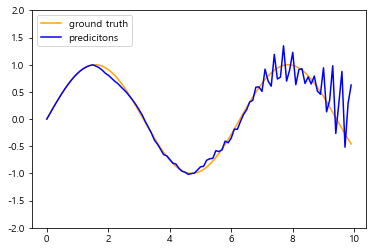

In [15]:
# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange") # 타겟, 실제값
plt.plot(test_x, test_y, label="predicitons", color="blue") # 예측 값
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()